# Interactive Simulation using Vivarium

## Debug
- Moviewriter (is it just not capable on Windows? I don't get subprocess bug)
- package (why can't I import vivarium_examples?)
- Why can't I use the 'simulation_end' event? 
- How to control population size? 

## TODO - 
- How to ensure multiple flocks? One way is that they'll only flock with boids of the same color
- should each individual and/or cluster (but clusters aren't consisent) get some sort of acceleration that can be toggled at the cluster level? (maybe I should just be affecting acceleration, NOT velocity)
- Maximum flock size? (either absolute, or set a maximum number of flocks). Yes, that allows you to avoid the color dilemma, but still control flocks (and more logically, based on proximity)
    - should I actually be doing NNearestNeighbors, or some clustering algorithm that will give me distinct groups (rather than getting all birds within X distance). Is there an implemetnation 
- Flocking weighted by distance
- Personal space
- Velocity as a value pipeline, then a flocking component that uses neighbor pipeline to change value pipeline


## Long term - 
- be able to run distributed runner
    - get the movies across parameter space
    - get infection curves, with uncertainty 

In [1]:
import numpy as np
import pandas as pd

from scipy import spatial

import matplotlib.pyplot as plt

from IPython.display import HTML

In [263]:

class Population:

    configuration_defaults = {
        'boids': {
            'population_size': 100,
            'colors': ['red', 'blue'],
        }
    }

    def setup(self, builder):
        self.colors = builder.configuration.boids.colors

        columns_created = ['color', 'entrance_time']
        builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
        self.population_view = builder.population.get_view(columns_created)

    def on_initialize_simulants(self, pop_data):
        new_population = pd.DataFrame({
            'color': np.random.choice(self.colors, len(pop_data.index)),
            'entrance_time': pop_data.creation_time,
        }, index=pop_data.index)
        self.population_view.update(new_population)

        
class Location:

    configuration_defaults = {
        'location': {
            'max_velocity': 20,
            'width': 1000,   # Width of our field
            'height': 1000,  # Height of our field
        }
    }

    def setup(self, builder):
        self.width = builder.configuration.location.width
        self.height = builder.configuration.location.height
        self.max_velocity = builder.configuration.location.max_velocity

        columns_created = ['x', 'vx', 'y', 'vy']
        builder.population.initializes_simulants(self.on_create_simulants, columns_created)
        builder.event.register_listener('time_step', self.on_time_step)
        self.population_view = builder.population.get_view(columns_created)

    def on_create_simulants(self, pop_data):
        count = len(pop_data.index)
        # Start clustered in the center with small random velocities
        new_population = pd.DataFrame({
            'x': np.random.uniform(0, self.width, count), # self.width * (0.4 + 0.2 * np.random.random(count)),
            'y': np.random.uniform(0, self.height, count), # self.height * (0.4 + 0.2 * np.random.random(count)),
            'vx': self.max_velocity * np.random.randn(count), # -0.5 + np.random.random(count),
            'vy': self.max_velocity * np.random.randn(count), # -0.5 + np.random.random(count),
        }, index= pop_data.index)
        self.population_view.update(new_population)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        
        # Limit velocity
        pop.loc[pop.vx > self.max_velocity, 'vx'] = self.max_velocity
        pop.loc[pop.vx < -self.max_velocity, 'vx'] = -self.max_velocity
        pop.loc[pop.vy > self.max_velocity, 'vy'] = self.max_velocity
        pop.loc[pop.vy < -self.max_velocity, 'vy'] = -self.max_velocity
        
        pop['x'] = pop.apply(lambda row: self.move_boid(row.x, row.vx, self.width), axis=1)
        pop['vx'] = pop.apply(lambda row: self.avoid_wall(row.x, row.vx, self.width), axis=1)
        pop['y'] = pop.apply(lambda row: self.move_boid(row.y, row.vy, self.height), axis=1)
        pop['vy'] = pop.apply(lambda row: self.avoid_wall(row.y, row.vy, self.height), axis=1)
        
        self.population_view.update(pop)
        
        
        
    def move_boid(self, position, velocity, limit):
        if in_boundary(position, velocity, limit):
            return position + velocity
        else: 
            return position
        
    def avoid_wall(self, position, velocity, limit):
        if in_boundary(position, velocity, limit):
            return velocity
        else: 
            return velocity * -1
        
def in_boundary(position, velocity, limit):
    return (position + velocity < limit) & (position + velocity > 0)
        
        
# class Neighbors:

#     configuration_defaults = {
#         'neighbors': {
#             'radius': 10
#         }
#     }

#     def setup(self, builder):
#         self.radius = builder.configuration.neighbors.radius

#         self.neighbors_calculated = False
#         self._neighbors = pd.Series()
#         self.neighbors = builder.value.register_value_producer('neighbors', source=self.get_neighbors)

#         builder.population.initializes_simulants(self.on_create_simulants)
#         self.population_view = builder.population.get_view(['x', 'y'])

#         builder.event.register_listener('time_step', self.on_time_step)

#     def on_create_simulants(self, pop_data):
#         self._neighbors = pd.Series([[]] * len(pop_data.index), index=pop_data.index)

#     def on_time_step(self, event):
#         self.neighbors_calculated = False

#     def get_neighbors(self, index):
#         if not self.neighbors_calculated:
#             self.calculate_neighbors()
#         return self._neighbors[index]

#     def calculate_neighbors(self):
#         # Reset our list of neighbors
#         pop = self.population_view.get(self._neighbors.index)
#         self._neighbors = pd.Series([[]] * len(pop), index=pop.index)

#         tree = spatial.KDTree(pop)

#         # Iterate over each pair of simulates that are close together.
#         for boid_1, boid_2 in tree.query_pairs(self.radius):
#             # .iloc is used because query_pairs uses 0,1,... indexing instead of pandas.index
#             self._neighbors.iloc[boid_1].append(self._neighbors.index[boid_2])
#             self._neighbors.iloc[boid_2].append(self._neighbors.index[boid_1])

In [191]:
class Flock:
    
    configuration_defaults = {
        'neighbors': {
            'radius': 10
        }
    }
    
    def setup(self, builder):
        self.radius = builder.configuration.neighbors.radius

        builder.event.register_listener('time_step', self.on_time_step, priority=0)
        self.population_view = builder.population.get_view(['x', 'y', 'vx', 'vy'])

    def on_create_simulants(self, pop_data):
        count = len(pop_data.index)
        # Start clustered in the center with small random velocities
        new_population = pd.DataFrame({
            'x': self.width * (0.4 + 0.2 * np.random.random(count)),
            'y': self.width * (0.4 + 0.2 * np.random.random(count)),
            'vx': 10 * np.random.randn(count), # -0.5 + np.random.random(count),
            'vy': 10 * np.random.randn(count), # -0.5 + np.random.random(count),
        }, index= pop_data.index)
        self.population_view.update(new_population)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)

        self._neighbors = pd.Series([[]] * len(pop), index=pop.index)

        tree = spatial.KDTree(pop[['x', 'y']])

        # Iterate over each pair of simulants that are close together.
        for boid_1, boid_2 in tree.query_pairs(self.radius):
            # .iloc is used because query_pairs uses 0,1,... indexing instead of pandas.index
#             if pop.iloc[boid_1].color == pop.iloc[boid_2].color:
            self._neighbors.iloc[boid_1].append(self._neighbors.index[boid_2])
            self._neighbors.iloc[boid_2].append(self._neighbors.index[boid_1])

        for i in event.index:
            neighbors = self._neighbors[i]
            # RULE 1: Match velocity 
            pop.iloc[i].vx += 0.2 * pop.iloc[neighbors].vx.mean()
            pop.iloc[i].vy += 0.2 * pop.iloc[neighbors].vy.mean()
        
            # RULE 2: velocity toward center of mass 
            pop.iloc[i].vx += 0.2 * (pop.iloc[neighbors].x.mean() - pop.iloc[i].x)
            pop.iloc[i].vy += 0.2 * (pop.iloc[neighbors].y.mean() - pop.iloc[i].y)
        
        self.population_view.update(pop)

In [430]:
from sklearn.cluster import KMeans

class FlockKMeans:
    
    configuration_defaults = {
        'neighbors': {
            'n_neighbors': 8
        }
    }
    
    def setup(self, builder):
        self.n_neighbors = builder.configuration.neighbors.n_neighbors
        self.kmeans = KMeans(self.n_neighbors, random_state=0)
        columns_created = ['cluster']
        builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
        builder.event.register_listener('time_step', self.on_time_step, priority=0)
        self.population_view = builder.population.get_view(['x', 'y', 'vx', 'vy'] + columns_created)
    
    def on_initialize_simulants(self, pop_data):
        # Can't seem to use other columns during initialization
#         pop = self.population_view.get(pop_data.index)
#         self.kmeans.fit(pop[['x', 'y']])
#         pop['cluster'] = self.kmeans.labels_
        pop = pd.DataFrame({
            'cluster': [1] * len(pop_data.index),
            })
        self.population_view.update(pop)

    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        self.kmeans.fit(pop[['x', 'y']])
        pop['cluster'] = self.kmeans.labels_
        pop.cluster = pop.cluster.astype('int64')  # picky picky Vivarium
        clusters = pop.groupby('cluster')[['x', 'y', 'vx', 'vy']].mean()
        
        # RULE 2: velocity toward center of mass 
        pop['vx'] = pop.apply(lambda row: 1 * row.vx + 0.05 * (clusters.iloc[int(row.cluster)].x - row.x),
                             axis=1)
        pop['vy'] = pop.apply(lambda row: 1 * row.vy + 0.05 * (clusters.iloc[int(row.cluster)].y - row.y),
                             axis=1)
                              
        # RULE 1: Match velocity 
        pop['vx'] = pop.apply(lambda row: 1 * row.vx + 0.1 * clusters.iloc[int(row.cluster)].vx,
                             axis=1)
        pop['vy'] = pop.apply(lambda row: 1 * row.vy + 0.1 * clusters.iloc[int(row.cluster)].vy,
                             axis=1)
        
        # RULE 3: give cluster some acceleration (for now, same for x and y)
        clusters['a'] = 5*np.random.randn(self.n_neighbors)
        pop['vx'] = pop.apply(lambda row: row.vx + clusters.iloc[int(row.cluster)].a, axis=1)
        pop['vy'] = pop.apply(lambda row: row.vy + clusters.iloc[int(row.cluster)].a, axis=1)
          
        self.population_view.update(pop)

In [362]:
idx = np.random.choice(pop.index, 2)
pop.iloc[idx]

,tracked,color,entrance_time,y,vx,vy,x,cluster
9,True,red,2005-07-01,669.478784,0.354663,-20.294969,49.530515,1
15,True,blue,2005-07-01,50.224109,-16.108323,-30.415655,554.183316,1


In [431]:
class Infection:
    
    configuration_defaults = {
        'infection': {
            'radius': 100,
            'n_start':1,
        }
    }
    
    def setup(self, builder):
        self.radius = builder.configuration.infection.radius
        self.n_start = builder.configuration.infection.n_start

        columns_created = ['infected']
        builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
        builder.event.register_listener('time_step', self.on_time_step)
        self.population_view = builder.population.get_view(['x', 'y'] + columns_created)

    def on_initialize_simulants(self, pop_data):
        
        infection = pd.DataFrame({
            'infected': 0,
        }, index= pop_data.index)
        idx = np.random.choice(pop_data.index, self.n_start)
        infection.loc[idx, 'infected'] = 1
        self.population_view.update(infection)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)

        infected0 = pop.loc[pop.infected == 1].index.tolist()

        tree = spatial.KDTree(pop[['x', 'y']])
        pairs = tree.query_pairs(self.radius)
        
        infected1 = []
        # Iterate over each pair of simulants that are close together.
        for boid_1, boid_2 in tree.query_pairs(self.radius):
            if any([boid_1 in infected, boid_2 in infected0]):
                infected1 += [boid_1, boid_2]
        
        pop.loc[infected1, 'infected'] = 1
       
        self.population_view.update(pop)

In [425]:
import os
import shutil
import imageio

color_map = {0:'black', 1:'red', 2:'blue', 3:'yellow', 4:'green', 5:'brown', 6:'gray', 7:'orange'}


class SaveFrames:
     """
    Save one frame per step, that can then be assembled into GIF
    This is a hack because MovieWriter doesn't seem to work on Windows
    :param fname: the repo within which frames will be saved
    :param plot_type: whether to plot color as cluster or infection
    """
        
    def __init__(self, fname, plot_type='infection'):
        self.fname = fname
        self.plot_type = plot_type
        self.step = 1
        self.path = f'images/{self.fname}'
        shutil.rmtree(self.path, ignore_errors=True)
        os.mkdir(self.path)
            
    def setup(self, builder):
        self.width = builder.configuration.location.width
        self.height = builder.configuration.location.height
        builder.event.register_listener('time_step', self.on_time_step) #priority??? Before or after they actually move? 
        builder.event.register_listener('simulation_end', self.save_movie)
        cols = ['x', 'y', 'vx', 'vy']
        if self.plot_type == 'cluster':
            cols.append('cluster')
        elif self.plot_type == 'infection':
            cols.append('infected')
        self.population_view = builder.population.get_view(cols)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        if self.plot_type == 'cluster':
            pop['color'] = pop.cluster.map(color_map)
        elif self.plot_type == 'infection':
            pop['color'] = pop.infected.map(color_map)
        else:
            raise AssertionError(f'{self.plot_type} not recognized')
        
        plt.clf()
        self.plot_boids(pop)
        
        plt.savefig(f'{self.path}/step_{self.step}.png')
        self.step += 1

    def plot_boids(self, pop):
        plt.figure(figsize=[12, 12])
        plt.scatter(pop.x, pop.y, color=pop.color)
        plt.quiver(pop.x, pop.y, pop.vx, pop.vy, color=pop.color, width=0.002)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis([0, self.width, 0, self.height])
        
    def save_movie(self, event):
        # FIXME - this doesn't work - here's a hack to turn frames into gif after sim
        # import imageio
        # image_directory = 'images/test'
        # images = [i for i in os.listdir(image_directory) if 'png' in i]
        # images = [f'step_{i}.png' for i in range(1, len(images) + 1)]
        # with imageio.get_writer(f'{image_directory}/movie.gif', mode='I', fps=2) as writer:
        #     for i in images:
        #         image = imageio.imread(f'{image_directory}/{i}', format='png')
        #         writer.append_data(image)
                
        images = [i for i in os.listdir(self.path) if 'png' in i]
        import pdb; pdb.set_trace()
        with imageio.get_writer(f'{self.path}/movie.gif', mode='I', fps=2) as writer:
            for i in images:
                image = imageio.imread(f'{self.path}/{i}', format='png')
                writer.append_data(image)
        
        
# with MovieWriter('flock.gif') as mw:
#     components = [Population(), Location(), Flock(), mw]
#     sim = setup_simulation(components)
#     sim.take_steps(20)

In [439]:
class Observer:
    def __init__(self, colname):
        self.colname = colname
#         self.step = 1
        self.data = []
            
    def setup(self, builder):
        builder.event.register_listener('time_step', self.on_time_step, priority = 9)
        builder.event.register_listener('simulation_end', self.save_data)
        self.population_view = builder.population.get_view([self.colname])
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        self.data.append(pop[self.colname].mean())
        
    def save_data(self, event):
        df = pd.DataFrame({
            self.colname: self.data,
        })
        df.to_hdf(f'{self.colname}.hdf', key=colname)
    

In [440]:
from vivarium.interface import setup_simulation
# from vivarium_examples.boids.population import Population

components = [Population(), Location(), Infection(), FlockKMeans(), SaveFrames('test'), Observer('infected')] # SaveFrames('test'), FlockKMeans(), Infection()
sim = setup_simulation(components)

In [441]:
pop = sim.population.population
pop.head()

,tracked,color,entrance_time,y,vx,vy,x,infected,cluster
0,True,red,2005-07-01,5.776539,-17.321857,-18.138697,204.096330,0,1
1,True,blue,2005-07-01,868.026851,13.656344,-10.935059,139.132800,0,1
2,True,blue,2005-07-01,661.419805,-4.927853,3.469877,605.294023,0,1
3,True,red,2005-07-01,140.171551,-8.890379,-9.932011,773.422381,0,1
4,True,red,2005-07-01,447.550241,-3.208746,20.578428,496.388654,0,1


<Figure size 432x288 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

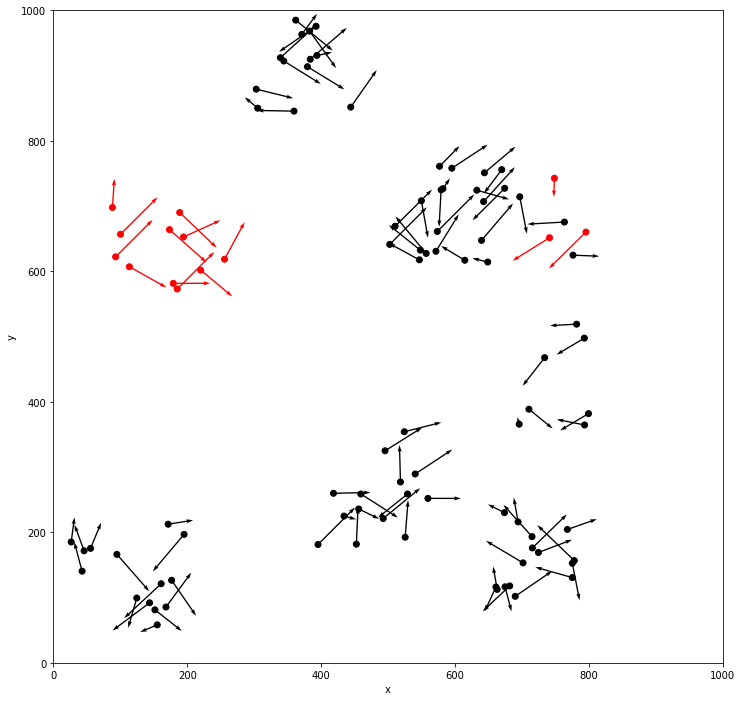

In [442]:
sim.take_steps(10)

In [435]:
import imageio
image_directory = 'images/test'
images = [i for i in os.listdir(image_directory) if 'png' in i]
images = [f'step_{i}.png' for i in range(1,len(images)+1)]
with imageio.get_writer(f'{image_directory}/movie.gif', mode='I', fps=2) as writer:
    for i in images:
        image = imageio.imread(f'{image_directory}/{i}', format='png')
        writer.append_data(image)

In [101]:
import seaborn as sns
def plot_birds(simulation, plot_velocity=True):
    width = simulation.configuration.location.width
    height = simulation.configuration.location.height
    pop = simulation.population.population

    plt.figure(figsize=[12, 12])
    sns.scatterplot(pop.x, pop.y, hue=pop.cluster)
    if plot_velocity:
        plt.quiver(pop.x, pop.y, pop.vx, pop.vy, color=pop.cluster, width=0.002)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis([0, width, 0, height])
    plt.show()

In [257]:
pop = sim.population.population
pop['color'] = pop.cluster.map(color_map)
pop['color'] = pop.cluster.map(color_map)
plt.scatter(pop.x, pop.y, color=pop.color)
plt.quiver(pop.x, pop.y, pop.vx, pop.vy, color=pop.color, width=0.002)

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [256]:
from vivarium.interface import setup_simulation
# from vivarium_examples.boids.population import Population

components = [Population(), Location(), Flock()]
sim = setup_simulation(components)

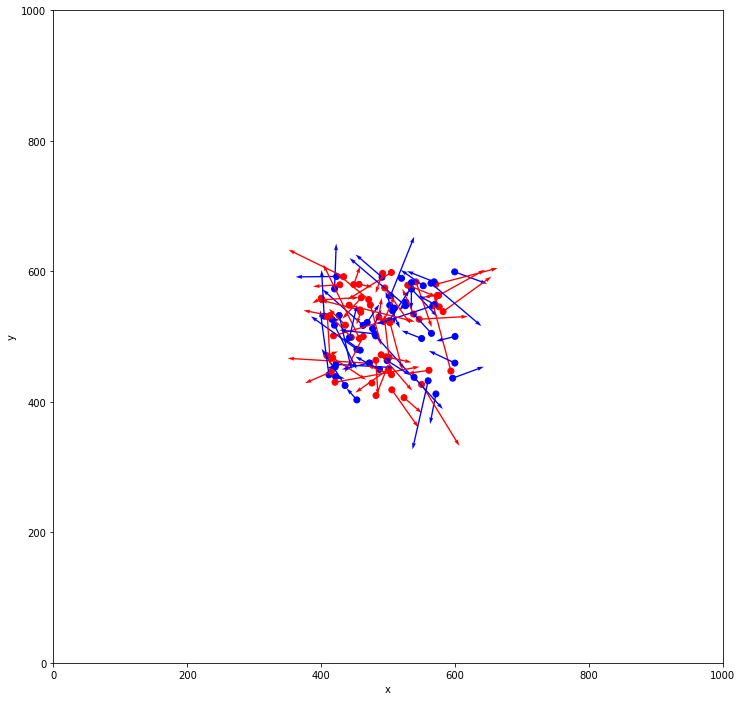

In [214]:
plot_birds(sim, plot_velocity=True)

In [215]:
sim.take_steps(1)

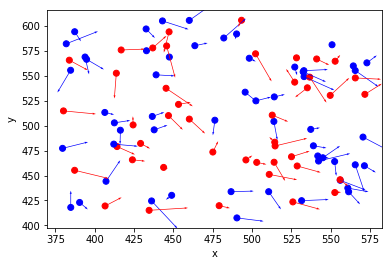

In [57]:
import seaborn as sns
def my_plot(df):
    # is there an easy way to plot the velocities?
#     xx = []
#     yy = []
#     for i in df.index:
#         xx += [df.x[i], df.x[i]+df.vx[i], np.nan]
#         yy += [df.y[i], df.y[i]+df.vy[i], np.nan]

#     plt.plot(xx, yy, sns.xkcd_rgb['light blue'])
#     plt.scatter(df.x, df.y)

#     plt.figure(figsize=[12, 12])
    plt.scatter(df.x, df.y, color=df.color)
    plt.quiver(df.x, df.y, df.vx, df.vy, color=df.color, width=0.002)
    plt.xlabel('x')
    plt.ylabel('y')
#     plt.axis([0, self.width, 0, self.height])

my_plot(sim.population.population)

In [84]:
from matplotlib import animation



class MovieWriter
    """
    Saves a gif of simulation
    NOTE - doesn't seem to work on Windows
    Usage: 
    with MovieWriter('flock.gif') as mw:
        components = [Population(), Location(), Flock(), mw]
        sim = setup_simulation(components)
        sim.take_steps(20)
    """

    def __init__(self, fname):
        self.moviewriter = animation.ImageMagickWriter(fps=2)
        self.fname = fname
            
    def __enter__(self):
        fig = plt.figure()
        self.moviewriter.setup(fig, self.fname, dpi=100)
        return self
    
    def setup(self, builder):
        self.width = builder.configuration.location.width
        self.height = builder.configuration.location.height
        builder.event.register_listener('time_step', self.on_time_step)
        self.population_view = builder.population.get_view(['x', 'y', 'vx', 'vy', 'color'])
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        
        plt.clf()
        self.plot_boids(pop)
        
        self.moviewriter.grab_frame()

    def plot_boids(self, pop):
#         plt.figure(figsize=[12, 12])
        plt.scatter(pop.x, pop.y, color=pop.color)
        plt.quiver(pop.x, pop.y, pop.vx, pop.vy, color=pop.color, width=0.002)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis([0, self.width, 0, self.height])
        
    def __exit__(self, exception_type, exception_value, traceback):
        self.moviewriter.finish()

with MovieWriter('flock.gif') as mw:
    components = [Population(), Location(), Flock(), mw]
    sim = setup_simulation(components)
    sim.take_steps(20)

OSError: [WinError 87] The parameter is incorrect

<Figure size 432x288 with 0 Axes>

In [130]:
HTML('<img src="flock.gif">')

OSError: [WinError 87] The parameter is incorrect

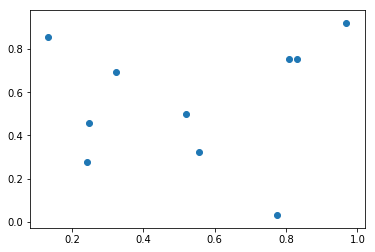

<Figure size 432x288 with 0 Axes>

In [85]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

x = np.random.random(10)
y = np.random.random(10)
plt.scatter(x,y)

moviewriter = animation.ImageMagickWriter(fps=1)
fig = plt.figure()
moviewriter.setup(fig, 'test.gif', dpi=100)
for i in range(0,10):
    plt.clf()
    x = np.random.random(10)
    y = np.random.random(10)
    plt.scatter(x,y)
    moviewriter.grab_frame()
moviewriter.finish()

In [86]:
moviewriter.setup?

In [213]:
with open('tempLog{0}.log'.format(os.getpid(),'w+') as f:
    subprocess.Popen(command, stdout=f, stderr=f)

SyntaxError: invalid syntax (<ipython-input-213-4666b0676058>, line 1)

In [212]:
moviewriter.setup?

In [201]:
sim.take_steps(10)

In [200]:
mw = MovieWriter('t.gif')
components = [Population(), Location(), mw]
sim = setup_simulation(components)

In [56]:
pop = sim.population.population

In [57]:
from scipy import spatial

In [58]:
tree = spatial.KDTree(pop[['x', 'y']])

In [62]:
tree.query_pairs(10)

{(4, 26), (35, 95), (50, 61), (54, 97)}

In [63]:
# Iterate over each pair of simulates that are close together.
for boid_1, boid_2 in tree.query_pairs(10):
    print(boid_1, boid_2)
    # .iloc is used because query_pairs uses 0,1,... indexing instead of pandas.index
#     self._neighbors.iloc[boid_1].append(self._neighbors.index[boid_2])
#     self._neighbors.iloc[boid_2].append(self._neighbors.index[boid_1])

4 26
35 95
54 97
50 61
